# Before We Begin
## Download Your Data
Download your own Facebook data via your account settings, "Your Facebook Information" > "Download Your Information". You can select the Date Range and Media Quality (I left both as default: "All of My Information" and "High"), BUT **make sure to change the format to JSON**. You will be notified when your data is ready for download. 

Once your data is ready and downloaded, you will receive a zip file titled "facebook-"your_username".zip". Decompress the zip and move the facebook-"your_username" folder into the /data folder of this repo. We will only be using the /facebook-"your_username"/messages/inbox folder, if you would like to modify the code to reference this folder directly. 

## Replace Your Folder Names

In [1]:
# Name of downloaded data zip file without the .zip extension. 
folderName = "facebook-mliu42"

# Your name as exactly listed on Facebook-- including all punctuation/spacing
# If you are unsure, use a text editor to open any message_?.json file in messages/inbox/<chat_name>.
# At the top you will see a list of Participants, one of which should be you. Copy the name listed there. 
myName = "Michelle Liu"

# If you would like to count the number of times a conversation references you by name, 
# insert all variants of your name here, including first name only, nicknames, mispellings, etc.
# If you would not like to track this, set myNameList = None, and the function will return 0 for all chats.
myNameList = ["Michelle Liu", "Michelle"] # or None

# Convert the JSONs into Readable Tables
First, let's turn these nested folders of JSON files into a database that we can easily read and parse through. We will be creating two DataFrames:

* **summaryTable**: contains summary statistics for each conversation, including the name of the chat, the participants, the total number of messages, and more!
* **messagesTable**: contains the content of each message as well as the chat it belongs to, who sent the message, and the date/time it was sent.

In [2]:
import matplotlib
import pandas as pd 
import numpy as np
import json
import os

# making plots
import matplotlib.pyplot as plt
import seaborn as sns

# math + calculations
import datetime
import math
from __future__ import division
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)

%config InlineBackend.figure_format = 'retina'

matplotlib.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

In [3]:
# helper methods for evaluating message content

# given a string, return the number of non-unicode characters and the number of words.
# unicode: ', ", emojis, special characters, etc.
def calculateCharAndWords(messageString):
    numWords = messageString.count(" ")
    numChars = len(messageString) - messageString.count("\u") * 6 # "\n####" unicode
    return numChars, numWords

# given a string, return the # instances of profanity.
def getProfanityCount(messageString):
    count = 0
    profanityList = [] # modify as needed
    for curse in profanityList:
        count += messageString.count(curse)
    return count

# given a string, return the # instances of your own name
def getMyNameCount(messageString):
    global myNameList
    count = 0
    if myNameList:
        for name in myNameList:
            count += messageString.lower().count(name.lower())
    return count

# given a string, return the polarity and subjectivity
# polarity = how positive or negative your string is [-1.0 = most negative, 1.0 = most positive]
# subjectivity = how subjective or objective your string is [0.0 = most objective, 1.0 = most subjective]
def getSentimentAnalysisScores(messageString):
    tb = TextBlob(messageString)
    return tb.sentiment.polarity, tb.sentiment.subjectivity

In [4]:
# helper methods for processing message.json files within a single conversation

# given a message.json file, return the conversation name and members
def getConvoNameAndMembers(messageJson):
    members = []
    for person in messageJson['participants']:
        members.append(person['name'])
    return messageJson['title'], members

# given a message.json file and the current stats for the conversation (before processing the current json file), 
# return a list of new message objects and the updated conversation stats 
def readMessages(messageJson, conversationStats):
    global myName
    messages = []

    # create a message object for each entry in the JSON file
    for entry in messageJson['messages']:
        if 'content' in entry:
            messageContent = entry['content']
            message = {
                'sender' : entry['sender_name'],
                'timestamp' : entry['timestamp_ms'],
                'content' : messageContent,
                'chatName' : messageJson['title'],
                'date' : datetime.datetime.fromtimestamp(entry['timestamp_ms'] / 1000)
            }
            messages.append(message)
            
            # update the first and last message times if needed
            if 'First Message Time' not in conversationStats or entry['timestamp_ms'] < conversationStats['First Message Time']:
                conversationStats['First Message Time'] = entry['timestamp_ms']
            if 'Last Message Time' not in conversationStats or entry['timestamp_ms'] > conversationStats['Last Message Time']:
                conversationStats['Last Message Time'] = entry['timestamp_ms']
            
            # update the conversation stats
            conversationStats['Num Chars'] += len(messageContent) - messageContent.count("\u") * 6 # "\n####" unicode
            conversationStats['Num Words'] += messageContent.count(" ")
            conversationStats['Num Sent By Me'] += 1 if entry['sender_name'] == myName else 0
            conversationStats['Profanity Count'] += getProfanityCount(messageContent)
            conversationStats['My Name Count'] += getMyNameCount(messageContent)
            polarity, subjectivity = getSentimentAnalysisScores(messageContent)
            conversationStats['Sentiment Polarity'] += polarity
            conversationStats['Sentiment Subjectivity'] += subjectivity
            
    return messages, conversationStats

In [7]:
index = 0 # index all interesting chats from 0

# process a single conversation, given the path to its directory
# path: data/<myFolderName>/messages/inbox/<conversation_name>
# returns the conversation statistics object and a list of all message objects
def processConversation(convo_dir_path): 
    global index
    chatName = ""
    members = []
    messages = []
    stats = {
        "Num Chars" : 0,
        "Num Words" : 0,
        "Num Sent By Me" : 0,
        "Profanity Count" : 0,
        "My Name Count" : 0,
        "Sentiment Polarity" : 0,
        "Sentiment Subjectivity": 0
    }

    # iterate through all message.json files
    for filename in os.listdir(convo_dir_path):
        if filename[:7] == 'message':
            with open(convo_dir_path + '/' + filename) as f:
                messageJson = json.load(f)
            if filename == 'message_1.json': # set chat name and members only once
                chatName, members = getConvoNameAndMembers(messageJson)
                
            # add new messages to messages list and conversation stats
            newMessages, stats = readMessages(messageJson, stats)
            messages += newMessages

    # check if the conversation is "interesting"
    # interesting is defined as: <= 12 members, > 2 messages, no deleted users (represented as "Facebook User")
    if len(members) <= 12 and not "Facebook User" in members and len(messages) > 2:
        # add identifying info
        stats['Chat ID'] = index
        index += 1
        
        stats['Chat Name'] = chatName
        stats['Chat Members'] = members
        stats['Num Messages'] = len(messages)
        stats['Directory Name'] = convo_dir_path[convo_dir_path.rfind('/') + 1:]
        
        # find the average polarity/subjectivity per message, instead of total sum
        stats['Sentiment Polarity'] = stats['Sentiment Polarity'] / len(messages)
        stats['Sentiment Subjectivity'] = stats['Sentiment Subjectivity'] / len(messages)
        
        return stats, messages
    else:
        return None, None

# process all conversations in the inbox folder, given the path 
# path: data/<myFolderName>/messages/inbox
# MAX_NUM_PROCESS: maximum # interesting conversations that will be processed, -1 to process all
# returns the messagesTable and summaryTable DataFrame objects
def processAllConversations(directoryPath, MAX_NUM_PROCESS=-1):
    summaryTable = pd.DataFrame()
    messagesTable = pd.DataFrame()
    progressIndex = 0 # used to print conversation processing progress
    
    # iterate through all valid conversation folders
    for item in os.listdir(directoryPath):
        convo_dir_path = directoryPath + '/' + item
        if os.path.isdir(convo_dir_path):
            # process the conversation, if not interesting will return (None, None)
            stats, messages = processConversation(convo_dir_path)
            if stats and (progressIndex < MAX_NUM_PROCESS or MAX_NUM_PROCESS == -1):
                progressIndex += 1
                if progressIndex % 20 == 0:
                    print("Processed conversation: " + str(index))
                else:
                    print("."),
                
                messagesTable = messagesTable.append(messages, ignore_index=True)
                summaryTable = summaryTable.append(stats, ignore_index=True)
                
    print("Finished processing all conversations 🤠")
    return messagesTable, summaryTable

In [8]:
directoryPath = 'data/' + folderName + '/messages/inbox'
messagesTable, summaryTable = processAllConversations(directoryPath, MAX_NUM_PROCESS=-1)

. . . . . . . . . . . . . . . . . . . Processed conversation: 20
. . . . . . . . . . . . . . . . . . . Processed conversation: 40
. . . . . . . . . . . . . . . . . . . Processed conversation: 60
. . . . . . . . . . . . . . . . . . . Processed conversation: 80
. . . . . . . . . . . . . . . . . . . Processed conversation: 100
. . . . . . . . . . . . . . . . . . . Processed conversation: 120
. . . . . . . . . . . . . . . . . . . Processed conversation: 140
. . . . . . . . . . . . . . . . . . . Processed conversation: 160
. . . . . . . . . . . . . . . . . . . Processed conversation: 180
. . . . . . . . . . . . . . . . . . . Processed conversation: 200
. . . . . . . . . . . . . . . . . . . Processed conversation: 220
. . . . . . . . . . . . . . . . . . . Processed conversation: 240
. . . . . . . . . . . . . . . . . . . Processed conversation: 260
. . . . . . . . . . . . . . . . . . . Processed conversation: 280
. . . . . . . . . . . . . . . . . . . Processed conversation: 300
. . . . . . . 

In [9]:
# additional summary table processing
summaryTable['Num Sent By Them'] = summaryTable['Num Messages'] - summaryTable['Num Sent By Me']
summaryTable['Percent Sent By Me'] = summaryTable['Num Sent By Me'] / summaryTable['Num Messages']
summaryTable['Profanity %'] = summaryTable['Profanity Count'] / summaryTable['Num Words'] * 100
summaryTable['Total Chat Length (days)'] = (summaryTable['Last Message Time'] - summaryTable['First Message Time']) / (60000 * 60 * 24)
summaryTable['Chat Density'] = summaryTable['Num Messages'] / summaryTable['Total Chat Length (days)']

# additional messages table processing
messagesTable['Month/Year'] = messagesTable['date'].apply(lambda x: datetime.date(x.year, x.month, 1))

In [10]:
summaryTable.sort_values('Num Messages', ascending=False)[:25]
# messagesTable

,Chat ID,Chat Members,Chat Name,Directory Name,First Message Time,Last Message Time,My Name Count,Num Chars,Num Messages,Num Sent By Me,Num Words,Profanity Count,Sentiment Polarity,Sentiment Subjectivity,Num Sent By Them,Percent Sent By Me,Profanity %,Total Chat Length (days),Chat Density
75,75.0,"[Raymond Zhu, Michelle Liu]",Raymond Zhu,RaymondZhu_2kSZBqr4fg,1.471645e+12,1.588263e+12,508.0,3180821.0,139345.0,61608.0,539229.0,3247.0,0.066137,0.231851,77737.0,0.442126,0.602156,1349.749001,103.237713
15,15.0,"[Amy Hu, Michelle Liu]",Amy Hu,AmyHu_Mn8zlmbfVA,1.301791e+12,1.588268e+12,5151.0,2817070.0,129948.0,61147.0,451151.0,1520.0,0.059676,0.201153,68801.0,0.470550,0.336916,3315.709220,39.191615
67,67.0,"[Eric Wang, Michelle Liu]",Eric Wang,EricWang_TVv33syrTA,1.548692e+12,1.583720e+12,185.0,1706802.0,60527.0,28586.0,297235.0,1196.0,0.089674,0.260997,31941.0,0.472285,0.402375,405.413119,149.297093
628,628.0,"[Jeremy Zou, Michelle Liu]",Jeremy Zou,JeremyZou_JOvOphA4Xg,1.368333e+12,1.543119e+12,397.0,592694.0,28924.0,15330.0,93925.0,252.0,0.051541,0.232442,13594.0,0.530010,0.268299,2022.986762,14.297671
408,408.0,"[Junho Park, Michelle Liu]",Junho Park,JunhoPark_iOlzZekT-w,1.337803e+12,1.588127e+12,232.0,571474.0,27960.0,12412.0,84150.0,368.0,0.077413,0.210313,15548.0,0.443920,0.437314,2897.267907,9.650471
85,85.0,"[Minji Kim, Soo Kim, Amanda Zhang, Michelle Li...",Band Squad ð,BandSquad_VJy_gO-RmA,1.495037e+12,1.583940e+12,334.0,634262.0,24094.0,1563.0,104720.0,789.0,0.086417,0.256697,22531.0,0.064871,0.753438,1028.975642,23.415520
558,558.0,"[Michelle Tzeng, Michelle Liu]",Michelle Tzeng,MichelleTzeng_SKcaQeZAFg,1.523669e+12,1.587738e+12,87.0,701586.0,22381.0,12553.0,125904.0,659.0,0.129677,0.304168,9828.0,0.560878,0.523415,741.546695,30.181511
313,313.0,"[Emily Wang, Michelle Liu]",Emily Wang,EmilyWang_tIAnealEbQ,1.513127e+12,1.588198e+12,56.0,557915.0,19864.0,9707.0,95216.0,452.0,0.075265,0.257848,10157.0,0.488673,0.474710,868.877869,22.861671
375,375.0,"[Daniel Kim, Michelle Liu]",Daniel Kim,DanielKim_6KMXGL9NIQ,1.348613e+12,1.588045e+12,169.0,469898.0,19562.0,8799.0,77634.0,454.0,0.060571,0.224809,10763.0,0.449801,0.584795,2771.198615,7.059039
26,26.0,"[Joseph Zhang, Michelle Liu]",Joseph Zhang,JosephZhang_0nB6hClmuw,1.344434e+12,1.583025e+12,80.0,417586.0,19368.0,8807.0,68743.0,452.0,0.071574,0.220952,10561.0,0.454719,0.657521,2761.473088,7.013648


# Interpret Your Data
## Visualize Your Top Chats
Now that our data is in an easy-to-use format, we can visualize some key insights. Which conversations have the most messages? Which conversations do you participate the most in? Which chats are the most profane? Which chats have the most messages per total time length of chat? The possibilities are endless...

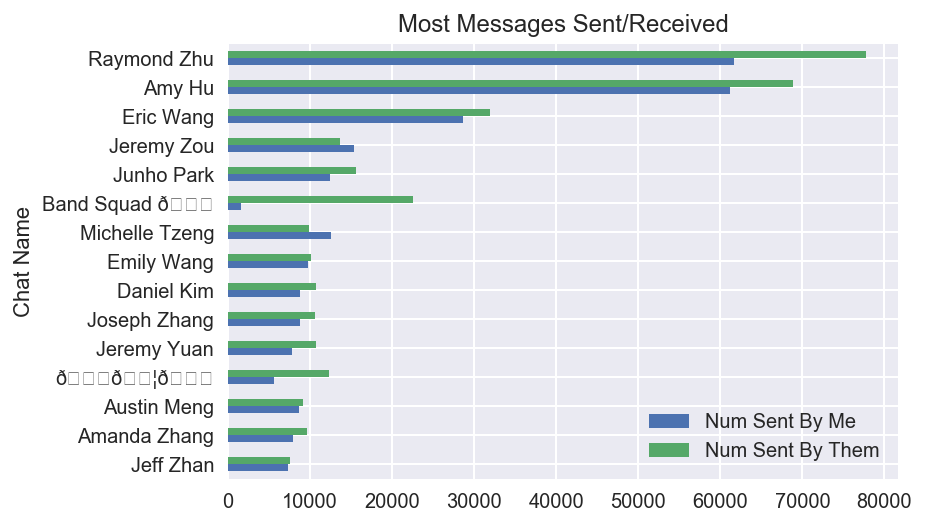

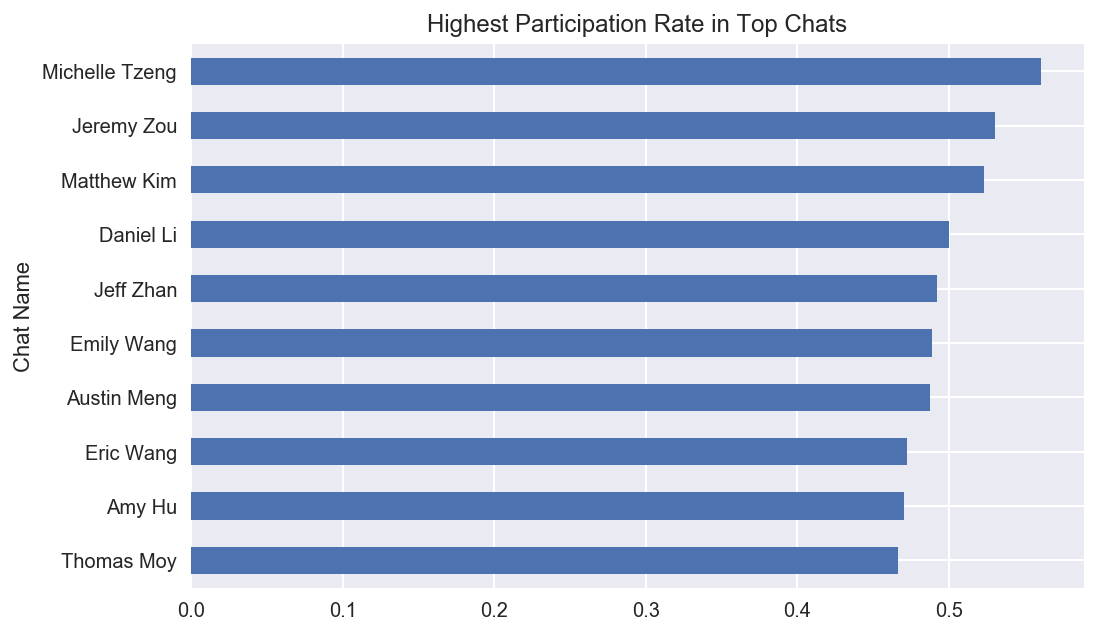

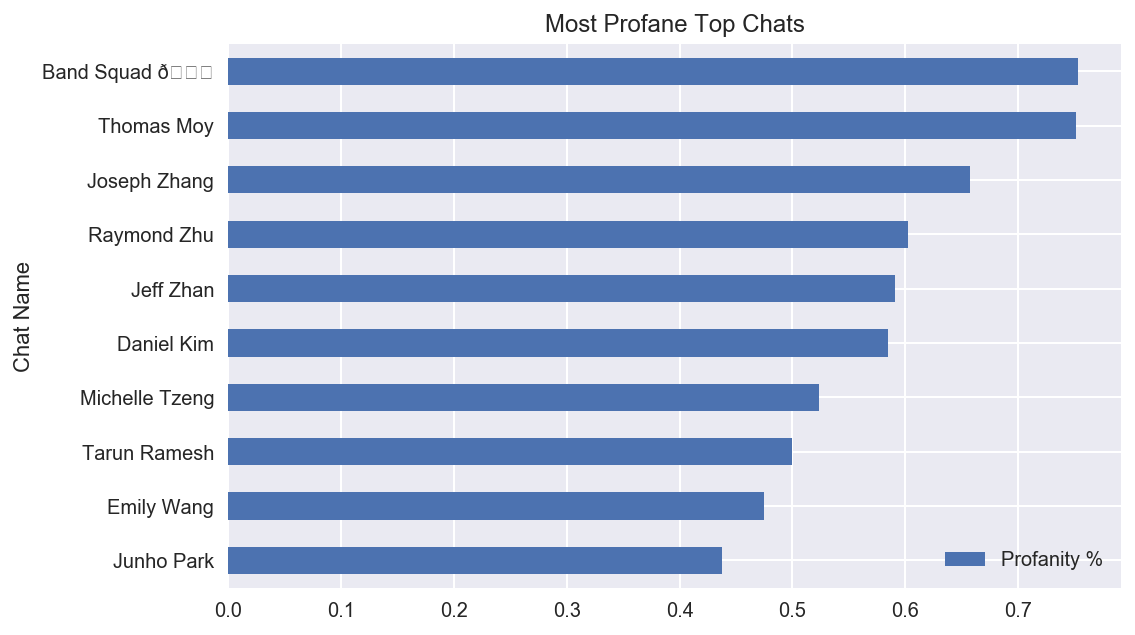

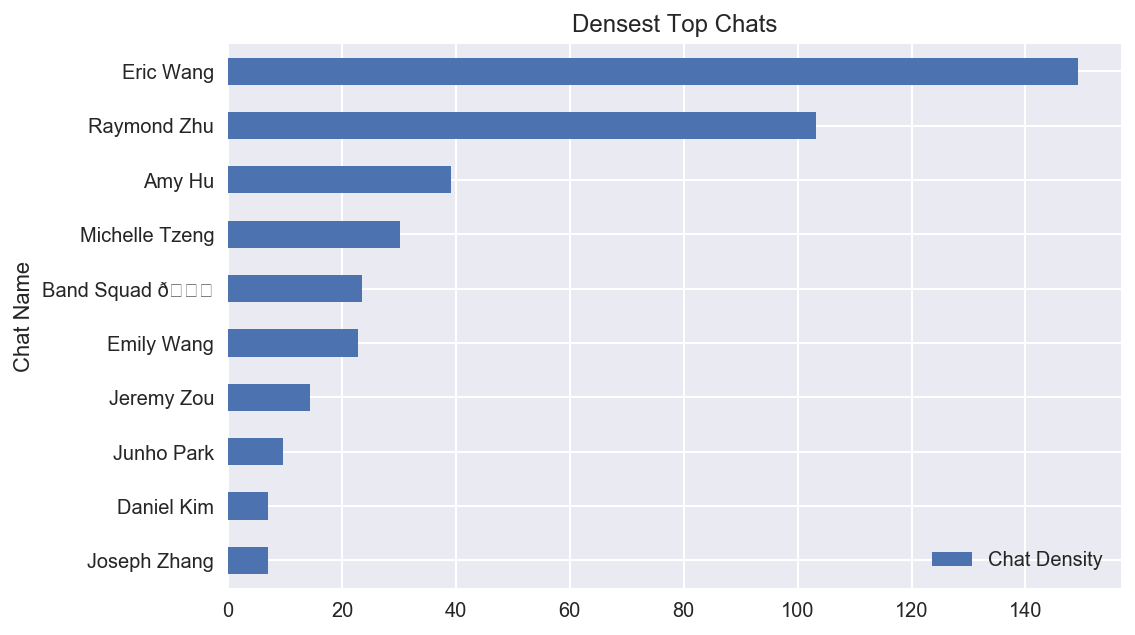

In [11]:
# Who have I sent the most messages to?
topTwentyMost = summaryTable.sort_values('Num Messages', ascending=False)[:20]
topTwentyMost[:15].sort_values('Num Messages', ascending=True).plot(
    x=['Chat Name'], y=['Num Sent By Me', 'Num Sent By Them'], kind="barh", title="Most Messages Sent/Received")

# Of my top 20 chats, which has my highest participation?
topTwentyMost.sort_values('Percent Sent By Me', ascending=True)[10:20].plot(
    x=['Chat Name'], y=['Percent Sent By Me'], kind="barh", 
    title="Highest Participation Rate in Top Chats", figsize=(8,5), legend=False)

# Of my top 20 chats, which chats are the most profane?
topTwentyMost.sort_values('Profanity %', ascending=True)[10:20].plot(
    x=['Chat Name'], y=['Profanity %'], kind="barh", 
    title="Most Profane Top Chats", figsize=(8,5), legend=True)

# Of my top 20 chats, which chats are the densest?
topTwentyMost[:10].sort_values('Chat Density', ascending=True).plot(
    x=['Chat Name'], y=['Chat Density'], kind="barh", 
    title="Densest Top Chats", figsize=(8,5))

plt.show()

,chatName,content,date,sender,timestamp,Month/Year
0,GT Final Failures,Same ð,2017-05-08 18:24:36.710,Amanda Zhang,1494282276710,2017-05-01
1,GT Final Failures,Sameeee ððð,2017-05-08 18:22:32.159,Jasmin Gao,1494282152159,2017-05-01
2,GT Final Failures,still got a weighted A,2017-05-08 18:18:08.241,Animesh Koratana,1494281888241,2017-05-01
3,GT Final Failures,21/40 on the frq ððð,2017-05-08 17:06:03.686,Animesh Koratana,1494277563686,2017-05-01
4,GT Final Failures,RIPPPP,2017-05-08 16:55:57.396,Michelle Liu,1494276957396,2017-05-01
5,GT Final Failures,Damn it I'll just email Martin then,2017-05-08 15:11:15.248,Amanda Zhang,1494270675248,2017-05-01
6,GT Final Failures,â ï¸ð,2017-05-08 15:11:07.428,Amanda Zhang,1494270667428,2017-05-01
7,GT Final Failures,no i dont think so lol,2017-05-08 14:39:51.075,Michelle Liu,1494268791075,2017-05-01
8,GT Final Failures,Wait did u guys get ubexcused for that day,2017-05-08 13:38:22.491,Amanda Zhang,1494265102491,2017-05-01
9,GT Final Failures,Wait it disappeared,2017-05-07 15:34:23.990,Amanda Zhang,1494185663990,2017-05-01


## Plot Your Activity Over Time

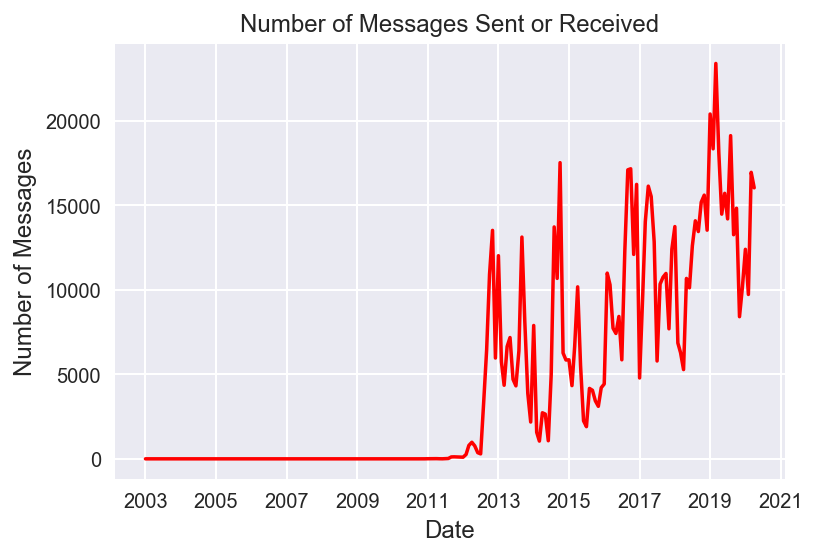

In [12]:
# show all message either sent or received over all time
messagesByMonthYear = messagesTable.groupby('Month/Year').count()[['content']].rename(columns={'content' : "Num Messages"})
graph = plt.plot(messagesByMonthYear, 'r-')
plt.title('Number of Messages Sent or Received')
plt.ylabel('Number of Messages', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.show()

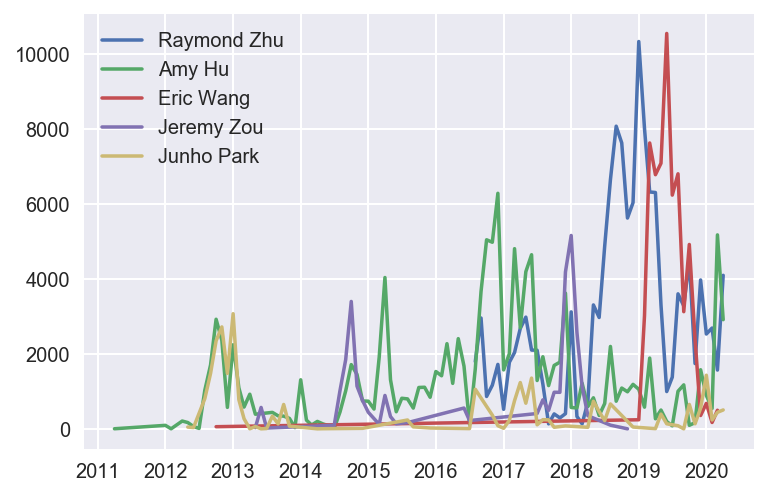

In [13]:
# given the name of the chat, return a list of the # messages per month 
def getMessageHistoryByChatName(chatName):
    global messagesTable
    return messagesTable.loc[messagesTable['chatName'] == chatName].groupby('Month/Year').count()[['content']]

# plot the texting patterns of your top 5 chats over time
topFiveChatNames = topTwentyMost['Chat Name'][:5]
for chatName in topFiveChatNames:
    plt.plot(getMessageHistoryByChatName(chatName))
    
plt.legend(topFiveChatNames)
plt.show()

## Tf-idf analysis
Tf-idf analysis refers to term frequency-inverse document frequency. In essence, it is a statistical measure that represents a word's relevance within a document. To calculate a word's tf-idf score, multiple the term frequency within a document to the inverse of the term's frequency across the entire set of documents. 

In my analyses, I use tf-idf to visualize notable words I used each month, given an input DataFrame. The resulting DataFrame can be showed inline or exported to a CSV file. I also ran several of my one-on-one conversations with my friends through tf-idf and shared the results with them, most of whom appreciated this little walk down memory lane :")

In [14]:
import gensim.downloader as gs
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import gensim.parsing.preprocessing as preprocessing

from string import ascii_letters, digits

In [15]:
# data cleaning helper methods

# returns if an input word is interesting and should not be filtered out
def isInterestingWord(word):
    # do not process irregular, non-ascii letters
    if set(word).difference(ascii_letters + digits):
        return False
    
    contractions = ['dont', 'doesnt', 'wont', 'cant', 'couldnt', 
                    'shouldnt', 'yall', 'isnt', 'wasnt','couldve', 
                    'wouldve','shouldve', 'im', 'its']
    abbreviations = ['thru', 'bc', 'idk', 'ur', 'hf', 'lol', 'ok', 'np', 'tbh', 'tbf', 'btw', 'nah', 'okey', 
                     'tmr', 'tn', 'sure', 'prob', 'said', 'tho', 'lmao', 'tho', 'its', 'ya', 'yah', 'rly', 
                     'ye', 'mm', 'ic', 'np', 'like']
    commonMispellings = ['juts', 'tahts']
    
    return not (word in contractions or word in abbreviations or word in commonMispellings or len(word) == 1 or len(word) > 30)

# given a string of words as data, remove irregularities and return a list of individual words
def clean(data):
    data = data.lower()
    data = preprocessing.remove_stopwords(data)
    symbols = "!@#$%^&*()_+-=:\/<>,.?[]{}|~"
    for symbol in symbols:
        data = data.replace(symbol, "")   
    words = data.split()
    return [word for word in words if isInterestingWord(word)]

In [16]:
# tf-idf processing

# given a DataFrame of all relevant messages, split them by a designated columnName to generate individual documents
# return list: [(columnValue, messageString), ...]
def getMessageListByColumn(messageTable, colName):
    messagesByGroup = []
    
    # for each group, isolate the relevant content in the messageTable and create the document to append to the list
    for group in messageTable[colName].drop_duplicates():
        allMessages = ""
        for content in messageTable.loc[messageTable[colName] == group]['content']:
            allMessages += content + " "
        messagesByGroup.append((group, allMessages))
        
    return messagesByGroup

# given a DataFrame of all relevant messages and the column to group them by, 
# return an object containing the most significant words in the format:
# [{
#       "colName" : GroupValue1, 
#       "Top Words": [(index, word, tf-idf ranking), ...],
#       "Polarity": pValue,
#       "Subjectivity" :sValue},  
#  ...
# ]
def getSignificantWords(messageTable, colName="Month/Year"):
    messageList = getMessageListByColumn(messageTable, colName)
    dataset = [clean(data) for data in (messageInfo[1] for messageInfo in messageList)]
    dct = Dictionary(dataset)
    corpus = [dct.doc2bow(line) for line in dataset]
    model = TfidfModel(corpus)
    
    topWordsByGroup = []
    for i in range(len(dataset)):
        vector = model[corpus[i]]
        sortedTuples = sorted(vector, key=lambda item:item[1], reverse=True) # sort returned words by rank
        formattedTuples = [(word[0], dct[word[0]], word[1]) for word in sortedTuples] # add "translated" word for readability
        polarity, subjectivity = getSentimentAnalysisScores(messageList[i][1]) # sentiment analysis for all words within the document
        
        topWordsByGroup.append({
            colName : messageList[i][0],
            "Top Words" : formattedTuples,
            "Polarity" : polarity,
            "Subjectivity" : subjectivity
        })
    
    return topWordsByGroup

# given the significant words object, return a readable DataFrame with the top X words of each group
def formatSignificantWordsToDF(sigWords, num_words_to_show=10):
    prettyTable = pd.DataFrame()
    groupName = sigWords[0].keys()[0]
    
    for entry in sigWords:
        row = {}
        row[groupName] = entry['Month/Year']
        for i in range(min(num_words_to_show, len(entry['Top Words']))):
            index, word, rank = entry['Top Words'][i]
            row["Word " + str(i)] = word + " (" + str(round(rank, 3)) + ")"
        row['Polarity'] = entry['Polarity']
        row['Subjectivity'] = entry['Subjectivity']
        prettyTable = prettyTable.append(row, ignore_index=True)
        
    return prettyTable

In [17]:
# view the tf-idf for my sent messages over all time, grouped by month
myMessages = messagesTable.loc[messagesTable['sender'] == myName]
mySigWordsByMonth = getSignificantWords(myMessages, colName='Month/Year')
myMessagesDF = formatSignificantWordsToDF(mySigWordsByMonth)

myMessagesDF.sort_values('Month/Year', ascending=False).to_csv('exports/my_chats.csv', index=False)
myMessagesDF.sort_values('Month/Year', ascending=False)

,Month/Year,Polarity,Subjectivity,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
87,2020-04-01,0.132780,0.541070,remote (0.281),barrys (0.233),quarantine (0.178),bog (0.165),rmr (0.126),zoom (0.106),ops (0.102),exec (0.1),yikes (0.094),yeahh (0.094)
88,2020-03-01,0.128298,0.560500,coronavirus (0.188),quarantine (0.179),tiktok (0.177),barrys (0.171),carcassonne (0.144),rmr (0.128),yikes (0.115),ig (0.111),connor (0.1),quarantined (0.099)
89,2020-02-01,0.160435,0.554639,barrys (0.279),gai (0.2),bog (0.18),path (0.178),dest (0.177),tg (0.098),agent (0.095),wine (0.095),ig (0.091),christopher (0.091)
31,2020-01-01,0.151979,0.558992,barrys (0.262),bog (0.246),heritage (0.195),rmr (0.172),ig (0.135),jeffs (0.102),mixer (0.102),eric (0.098),tg (0.092),drunk (0.09)
38,2019-12-01,0.129150,0.559631,pcb (0.234),ig (0.198),bog (0.134),cocktails (0.116),classpass (0.115),31st (0.112),jeff (0.104),sry (0.099),springer (0.091),smth (0.089)
39,2019-11-01,0.142428,0.546971,bog (0.216),demo (0.141),asana (0.122),ig (0.122),tg (0.114),lib (0.109),polynomial (0.102),awh (0.098),seattle (0.097),managers (0.096)
40,2019-10-01,0.139814,0.550905,interview (0.342),interviews (0.157),msoft (0.125),mmm (0.124),babe (0.113),expo (0.111),ig (0.107),gre (0.103),hackgt (0.099),rn (0.099)
41,2019-09-01,0.122855,0.540853,theta (0.162),interview (0.159),rn (0.156),okeyy (0.136),garage (0.118),coding (0.118),culc (0.11),kbai (0.104),ig (0.103),babe (0.101)
42,2019-08-01,0.123009,0.551771,bog (0.213),tg (0.167),okeyy (0.16),theta (0.136),interviews (0.128),sry (0.114),rn (0.113),awh (0.112),babe (0.11),ig (0.109)
43,2019-07-01,0.156283,0.546662,rene (0.249),lyft (0.194),bog (0.176),uber (0.163),tg (0.13),intern (0.127),ig (0.121),eric (0.118),sry (0.103),babe (0.092)


In [29]:
# generate the tf-idf for all messages in a specific chat
def generateTfidfFromChatNameByMonth(chatName):
    queryMessages = messagesTable.loc[messagesTable['chatName'] == chatName]
    sigWordsByMonth = getSignificantWords(queryMessages, colName='Month/Year')
    queryMessagesDF = formatSignificantWordsToDF(sigWordsByMonth)
    queryMessagesDF.sort_values('Month/Year', ascending=False).to_csv('exports/' + chatName + '.csv', index=False)
    
    return queryMessagesDF.sort_values('Month/Year', ascending=False)

# if the chat name contains emojis, use the directory name to reference
def generateTfidfFromDirectoryNameByMonth(directoryName):
    chatName = summaryTable.loc[summaryTable['Directory Name'] == directoryName]['Chat Name'].iloc[0]
    return generateTfidfFromChatNameByMonth(chatName)

# generateTfidfFromChatNameByMonth("Michelle Tzeng")
# generateTfidfFromDirectoryNameByMonth("BandSquad_VJy_gO-RmA")

,Month/Year,Polarity,Subjectivity,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
9,2020-03-01,0.060503,0.628268,cancelled (0.295),hop (0.229),puerto (0.229),rico (0.229),rumor (0.229),advisory (0.142),bitchterium (0.142),cdc (0.142),choked (0.142),cockrona (0.142)
10,2020-02-01,0.209784,0.587054,valentines (0.369),2mas (0.229),improve (0.229),valentine (0.229),albert (0.227),homework (0.19),thriving (0.184),ahhhhhhhhhhhhhhhhh (0.184),bow (0.184),cupid (0.184)
11,2020-01-01,0.139773,0.530303,capstone (0.263),dan (0.263),dooooooo (0.263),moo (0.263),rsvp (0.263),thesis (0.263),whim (0.263),puerto (0.212),rico (0.212),ji (0.212)
12,2019-12-01,0.227171,0.569111,admin (0.355),stock (0.269),removed (0.269),disney (0.22),gopro (0.22),robin (0.22),referral (0.177),cgc (0.147),deposit (0.147),hood (0.147)
13,2019-11-01,0.222240,0.554776,judy (0.282),thanksgiving (0.279),fri (0.168),bbq (0.168),thankful (0.164),friday (0.146),breakers (0.141),hammered (0.141),sally (0.139),afternoon (0.112)
14,2019-10-01,0.149386,0.540793,psyc (0.268),cocktober (0.247),study (0.224),halloween (0.216),bcg (0.179),utility (0.179),java (0.177),marginal (0.144),bird (0.144),thots (0.144)
15,2019-09-01,0.081371,0.654317,transfer (0.338),chow (0.203),cookie (0.203),drivers (0.203),gps (0.203),gray (0.203),kimpton (0.203),madeline (0.203),mee (0.203),niceee (0.203)
16,2019-08-01,0.137500,0.581319,rush (0.248),915 (0.226),browsing (0.226),lands (0.226),lvea (0.226),rtinder (0.226),varsity (0.226),whatttt (0.226),aug (0.182),recruitment (0.182)
17,2019-07-01,0.269474,0.612934,cream (0.212),museum (0.212),river (0.176),restaurant (0.173),ramen (0.17),spot (0.155),expensive (0.153),amazing (0.14),japanese (0.136),chocolate (0.127)
18,2019-06-01,0.219314,0.412153,louisville (0.791),recs (0.161),weekend (0.145),sunday (0.139),arborteum (0.132),might (0.132),percentage (0.132),schlocked (0.132),scholarship (0.132),cities (0.106)


## Sentiment Analysis
Now that you know what you've been talking about, let's see if we can analyze how positive or negative your text was for a given time period. Are you generally happier in summer months? Are you generally more negative on Mondays?

In [20]:
# methods to plot sentiment values (polarity and/or subjectivity) over all-time or by month (line or scatter plots)
# optional to plotSubj, which will plot both values; otherwise, only polarity will be plotted

def ezNormalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0: 
        return vector
    return vector / norm

def plotSentimentAlltime(df, plotSubj, normalize):
    plt.title("Sentiment over Alltime Messages")
    plt.xlabel("Month in Year")
    
    # normalize arrays if needed
    if normalize:
        df['Polarity'] = ezNormalize(df['Polarity'])
        df['Subjectivity'] = ezNormalize(df['Subjectivity'])
        plt.title("Normalized Sentiment Over Alltime Messages")
    plt.plot(df['Month/Year'], df['Polarity'], 'r-')
    if plotSubj:
        plt.plot(df['Month/Year'], df['Subjectivity'], 'g-')
        
    plt.legend()
    plt.show()
    
def plotSentimentMonth(df, plotSubj, normalize):
    df['Month'] = df['Month/Year'].apply(lambda date: date.month)
    df['Year'] = df['Month/Year'].apply(lambda date: date.year)
    fig = plt.figure(1, figsize=(9, 10))
    ax = fig.add_subplot(211)
    ax.set_title("Chat Polarity over Month in Year")
    ax.set_xlabel("Month of the Year")
    ax.set_ylabel("Polarity [-1 to +1]")

    if plotSubj: # create a second subplot
        ax2 = fig.add_subplot(212)
        ax2.set_title("Chat Subjectivity over Month in Year")
        ax2.set_xlabel("Month of the Year")
        ax2.set_ylabel("Subjectivity [0 to +1]")
    # normalize arrays if needed
    if normalize:
        df['Polarity'] = ezNormalize(df['Polarity'])
        df['Subjectivity'] = ezNormalize(df['Subjectivity'])
        ax.set_title("Normalized Chat Polarity over Month in Year")
        if plotSubj:
            ax2.set_title("Normalized Chat Subjectivity over Month in Year")
            
    for year in df['Year'].drop_duplicates():
        ax.plot(df.loc[df['Year'] == year]['Month'], df.loc[df['Year'] == year]['Polarity'], "o", label=year)
        if plotSubj:
            ax2.plot(df.loc[df['Year'] == year]['Month'], df.loc[df['Year'] == year]['Subjectivity'], "^", label=year)

def plotSentiment(messagesDF, timespan='alltime', plotSubj=True, normalize=False):
    df = messagesDF.sort_values('Month/Year')
    if timespan is 'alltime':
        plotSentimentAlltime(df, plotSubj, normalize)
    elif timespan is 'month':
        plotSentimentMonth(df, plotSubj, normalize)
    else:
        print("Invalid timespan, please select from: alltime, month")

In [21]:
# methods to plot the spread of sentiment (polarity and/or subjectivity) over month or week (box-plots)
# optional to returnTable, which shows the box plot and returns a summary of the distribution scores

def plotSentimentSpreadMonth(df, plotSubj, returnTable):
    # sort sentiment data by month bucket
        df['Month'] = df['Month/Year'].apply(lambda date: date.month)
        polarityValuesByMonth = []
        subjectivityValuesByMonth = []
        for month in df['Month'].drop_duplicates():
            polarityValuesByMonth.append(df.loc[df['Month'] == month]['Polarity'])
            subjectivityValuesByMonth.append(df.loc[df['Month'] == month]['Subjectivity'])
        
        # create boxplot for polarity
        fig = plt.figure(1, figsize=(9, 10))
        ax = fig.add_subplot(211)
        polarityBox = ax.boxplot(polarityValuesByMonth)
        ax.set_title("Chat Polarity Distribution over Month in Year")
        ax.set_xlabel("Month of the Year")
        ax.set_ylabel("Polarity [-1 to +1]")
        # create second box plot for subjectivity
        if plotSubj:
            ax2 = fig.add_subplot(212)
            ax2.set_title("Chat Subjectivity Distribution over Month in Year")
            subjectivityBox = ax2.boxplot(subjectivityValuesByMonth)
            ax2.set_xlabel("Month of the Year")
            ax2.set_ylabel("Subjectivity [0 to +1]")
            
        if returnTable:
            return df.groupby('Month').describe().transpose()

def plotSentimentSpreadWeekDay(df, plotSubj, returnTable):
    # sort sentiment data by month bucket
        df['Day of Week'] = df['Month/Year'].apply(lambda date: date.weekday())
        polarityValuesByWeekDay = []
        subjectivityValuesByWeekDay = []
        for day in df['Day of Week'].drop_duplicates():
            polarityValuesByWeekDay.append(df.loc[df['Day of Week'] == day]['Polarity'])
            subjectivityValuesByWeekDay.append(df.loc[df['Day of Week'] == day]['Subjectivity'])
        
        # create boxplot for subjectivity
        fig = plt.figure(1, figsize=(9, 10))
        ax = fig.add_subplot(211)
        polarityBox = ax.boxplot(polarityValuesByWeekDay)
        ax.set_title("Chat Polarity Distribution over Day of Week")
        ax.set_xlabel("Day of Week")
        ax.set_ylabel("Polarity [-1 to +1]")
        # create second box plot for subjectivity
        if plotSubj:
            ax2 = fig.add_subplot(212)
            ax2.set_title("Chat Subjectivity Distribution over Day of Week")
            subjectivityBox = ax2.boxplot(subjectivityValuesByWeekDay)
            ax2.set_xlabel("Day of Week")
            ax2.set_ylabel("Subjectivity [0 to +1]")
            
        if returnTable:
            return df.groupby('Day of Week').describe().transpose()

# boxplots for showing distribution
def plotSentimentSpread(messagesDF, timespan='alltime', plotSubj=True, returnTable=True):
    df = messagesDF.sort_values('Month/Year')
    if timespan == 'month':
        return plotSentimentSpreadMonth(df, plotSubj, returnTable)
    elif timespan == 'day of week':
        return plotSentimentSpreadWeekDay(df, plotSubj, returnTable)
    else:
        print("Invalid timespan, please select from: month, day of week")

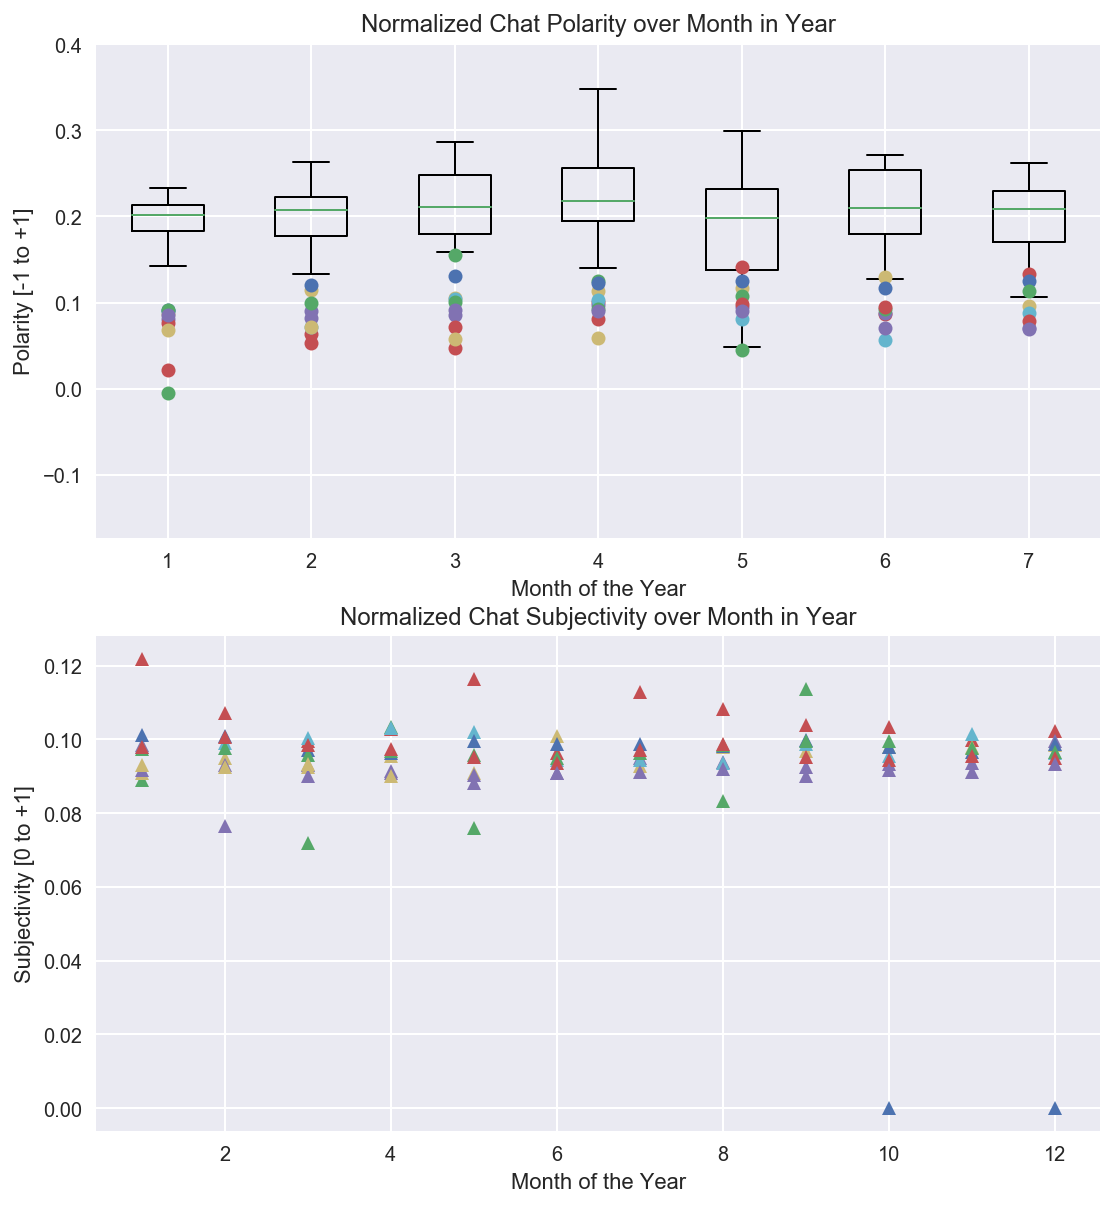

In [28]:
# plotSentimentSpread(myMessagesDF, timespan='month', plotSubj=False)
# plotSentimentSpread(myMessagesDF, timespan='day of week', plotSubj=False)
# plotSentiment(myMessagesDF, timespan='month', plotSubj=True, normalize=True)